In [1]:
import os
import pandas as pd
import pickle
import json
import seaborn as sns
import datetime
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt

import sqlite3

%matplotlib inline

pd.plotting.register_matplotlib_converters()


### <span style="color:navy"> **1. Diretórios Mapeados** </span>

In [2]:
parquet_file = '../../Data/Operacao/dados_coleta.parquet'

model_file =  '../../Data/Modeling/modelo_previsao.jbl'
save_result = '../../Data/Operacao/dados_result.parquet'


### <span style="color:navy"> **2. Carrega dados da API Pós-Preparação** </span>

In [3]:
dataframe = pd.read_parquet(parquet_file)


### <span style="color:navy"> **3. Carrega Modelo de Predição**</span>

In [4]:
with open(model_file, 'rb') as fid:
    trained_models = pickle.load(fid)

### <span style="color:navy"> **4. Informar Qual Modelo de Predição será Usado** </span>

In [5]:
model_name = 'LogisticRegr'
modelAquisicao = trained_models[model_name]

### <span style="color:navy"> **5. Executa Modelo de Predição sobre DadosAPI** </span>

In [6]:
X = dataframe['dsc_manutencao'].values.reshape(-1).tolist()

# Retorno de Probabilidade
Result_percentual = modelAquisicao.predict_proba(X)[:,1]

# Retorno de True e False
Result_boleano = modelAquisicao.predict(dataframe['dsc_manutencao'])


### <span style="color:navy"> **6. Criação de Novas Colunas no Dataframe para Receber Previsao** </span>

In [7]:
# RENOMEAR COLUNAS
dataframe.rename(columns={'dsc_manutencao': 'dsc_texto','tip_evento': 'tip_supervisao'}, inplace=True)

dataframe['din_execucao'] = datetime.datetime.now()
dataframe.din_execucao = dataframe.din_execucao.astype(str)

dataframe['tip_evento'] = dataframe.tip_supervisao
dataframe["tip_evento"].replace({"oper": "True", "prop": "False"}, inplace=True)

dataframe['tip_predicao'] = Result_boleano

dataframe['pct_predicao'] = Result_percentual
dataframe.pct_predicao = dataframe.pct_predicao.astype(float).round(3)*100


In [8]:
#for index,row in dataframe.iterrows():
     #dataframe.loc[index,'Resultc'] =  Result[index]

#for index,row in dataframe.iterrows():
     #dataframe.loc[index,'Resultprobc'] =  Resultprob[index] * 100        
        

### <span style="color:navy"> **7. Visualização de Dataframe Resultante** </span>

In [9]:
dataframe.head(5)

,id,dsc_texto,tip_supervisao,din_execucao,tip_evento,tip_predicao,pct_predicao
0,835269,verificar a causa do desligamento da unidade,oper,2020-09-08 00:16:03.177867,True,True,84.3
1,835267,ensaios operacionais de retorno da ug ao sis...,oper,2020-09-08 00:16:03.177867,True,True,98.3
2,835263,"manutencao, inspecao e limpeza no anel coletor",oper,2020-09-08 00:16:03.177867,True,True,91.5
3,835261,passivacao do oleo do transformador elevador t...,oper,2020-09-08 00:16:03.177867,True,True,96.3
4,835241,acompanhamento da operacao do bipolo em rvo ...,oper,2020-09-08 00:16:03.177867,True,False,14.1


### <span style="color:blue">**8. Graficos** </span>

#### <span style="color:blue"> **8.1 Quantitativos** </span>

In [10]:
print('')
print('')
print('1. Quantitativos de Registros Processados')
print('')



1. Quantitativos de Registros Processados



In [11]:
dataframe.tip_predicao.value_counts()

True     143
False    120
Name: tip_predicao, dtype: int64

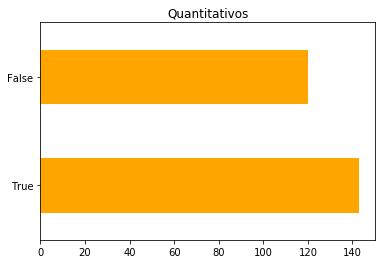

In [12]:
dataframe.tip_predicao.value_counts().plot(kind='barh',color="orange",title = "Quantitativos",subplots=False)

In [13]:
print('')
print('2. Boxplot - Distribuição das Porcentagem da Predição')
print('')


2. Boxplot - Distribuição das Porcentagem da Predição



#### <span style="color:blue"> **8.2 Boxplot - Distribuição das Porcentagem da Predição** </span>

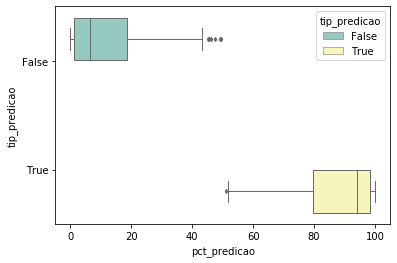

In [14]:
# linewidth= Grossura da linha
sns.boxplot(data=dataframe,orient="h",palette="Set3",linewidth=1,fliersize=3,x='pct_predicao',y="tip_predicao",hue="tip_predicao")

In [15]:
print('')
print('3. Distribuição das Porcentagem da Predição')
print('')


3. Distribuição das Porcentagem da Predição



#### <span style="color:blue"> **8.3 Distribuição das Porcentagem da Predição** </span>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C957CF348>,
      dtype=object)

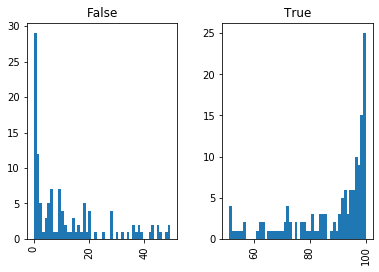

In [16]:
dataframe.hist(column="pct_predicao",by="tip_predicao",bins=50)

### <span style="color:navy"> **9 Exporta Resultado para Parquet** </span>

In [17]:
dataframe.to_parquet(save_result, compression='snappy')